# 5. Classification of Cancer or Non Cancer with hand picked features 

## Summary

* Find largest nodule in each patient sample and make a 64x64 crop over it
* Label as cancer or non-cancer. Alternatively, create random labels with same ratio of classes
* Use stratified K-fold to split data for cross validation
* Perform cross validation with CNN

In [35]:
#EDIT HERE##############################

#input list of image files, mask files, and tables generated from TrainUnet.ipynb

imageslist=['DSBNoduleImages.npy','DSBNoduleImages369-629.npy','DSBNoduleImages630-1199.npy','DSBNoduleImages1200-1594.npy', 'DSBNoduleImagesTest.npy']
maskslist=['DSBNoduleMasks.npy','DSBNoduleMasks369-629.npy','DSBNoduleMasks630-1199.npy','DSBNoduleMasks1200-1594.npy', 'DSBNoduleMasksTest.npy']
tablelist=['DSBPatientNoduleIndex.csv','DSBPatientNoduleIndex369-629.csv','DSBPatientNoduleIndex630-1199.csv','DSBPatientNoduleIndex1200-1594.csv', 'DSBPatientNoduleIndexTest.csv']
INPUT_FOLDER = 'stage1/'

########################################

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import dicom
import os
import scipy.ndimage
import time
from keras.callbacks import ModelCheckpoint
import h5py
from sklearn.cluster import KMeans
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


import random
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,log_loss
from sklearn.model_selection import cross_val_score
from scipy.ndimage.measurements import center_of_mass, label
from skimage.measure import regionprops
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import keras
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import plot_model
#from keras.utils import multi_gpu_model
import scipy as sp

def processimagenomask(img):
    #Standardize the pixel values
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    #plt.hist(img.flatten(),bins=200)
    #plt.show()
    #print(thresh_img[366][280:450])
    middle = img[100:400,100:400] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    #move the underflow bins
    img[img==max]=mean
    img[img==min]=mean
    return img

def largestnodulecoordinates(mask):
    #mask=nodulemasks[indx,0][0]
    mask[mask>0.5]=1
    mask[mask<0.5]=0
    labeled_array,nf=label(mask)
    areasinslice=[]
    if nf>1:
        for n in range(nf):
            lab=np.array(labeled_array)
            lab[lab!=(n+1)]=0
            lab[lab==(n+1)]=1
            areasinslice.append(np.sum(lab))
        nlargest=areasinslice.index(max(areasinslice))
        labeled_array[labeled_array!=(nlargest+1)]=0
        com=center_of_mass(labeled_array)
    else:
        com=center_of_mass(mask)
    return [int(com[0]),int(com[1])]

def largestnodulearea(mask,table,i):
    #mask=nodulemasks[indx,0][0]
    mask[mask>0.5]=1
    mask[mask<0.5]=0
    labeled_array,nf=label(mask)
    areasinslice=[]
    if nf>1:
        for n in range(nf):
            lab=np.array(labeled_array)
            lab[lab!=(n+1)]=0
            lab[lab==(n+1)]=1
            areasinslice.append(np.sum(lab))
        #nlargest=areasinslice.index(max(areasinslice))
        #labeled_array[labeled_array!=(nlargest+1)]=0
        return max(areasinslice)
    else:
        return table["Area"][i]

def crop_nodule(coord,image):
    dim=32
    return image[coord[0]-dim:coord[0]+dim,coord[1]-dim:coord[1]+dim]
#output: 64x64 images of the nodules with malignancy labels from the patient

    
patients = os.listdir(INPUT_FOLDER)


In [54]:
#Get largest nodule for each patient, make a 64x64 crop over processed image, label with malignancy label


table=pd.read_csv(tablelist[0])
if len(tablelist)>1:
    for file in tablelist[1:]:
        temptable=pd.read_csv(file)
        table=pd.concat([table,temptable])
table=table.reset_index()

table[:10]
malignantlabel=[]
malignancytable=pd.concat([pd.read_csv("stage1_labels.csv"),pd.read_csv("stage1_solution.csv")])
patients=malignancytable["id"].values
index=0
noduleexists=[]
nodulecrops=np.ndarray([len(patients),1,64,64])
indicies=[]
for i in range(len(imageslist)):
    print("loading file",imageslist[i])
    #del noduleimages, nodulemasks
    noduleimages=np.load(imageslist[i])
    nodulemasks=np.load(maskslist[i])
    tabletemp=pd.read_csv(tablelist[i])
    biggestnodulearea=[]
    for j in range(nodulemasks.shape[0]):
        biggestnodulearea.append(largestnodulearea(nodulemasks[j,0],tabletemp,j))
    tabletemp["LargestNoduleArea"]=pd.Series(biggestnodulearea)
    for patient in patients:
        nodulearea=tabletemp[["LargestNoduleArea"]].loc[tabletemp["Patient"]==patient]
        if len(nodulearea)>0:# and len(malignancytable["cancer"].loc[malignancytable["id"]==patient])>0:
            malignantlabel.append(malignancytable["cancer"].loc[malignancytable["id"]==patient].values[0].astype(np.bool))
            noduleexists.append(1)
            indx=nodulearea.loc[nodulearea["LargestNoduleArea"]==max(nodulearea["LargestNoduleArea"])].index[0]
            indicies.append(indx)
            nodcrop=crop_nodule(largestnodulecoordinates(nodulemasks[indx,0]),processimagenomask(noduleimages[indx,0]))
            if nodcrop.shape[0]*nodcrop.shape[1]<64**2:
                nodulecrops[index,0]=np.zeros([64,64])
                nodulecrops[index,0][0:nodcrop.shape[0],0:nodcrop.shape[1]]=nodcrop
            else:
                nodulecrops[index,0]=nodcrop
            index+=1
nodulecrops=nodulecrops[:index]
nodulecrops=nodulecrops.reshape(nodulecrops.shape[0],64,64,1)
features=table.iloc[indicies]
features["label"]=malignantlabel
TFratio=len([a for a in malignantlabel if a==True])/len(malignantlabel)
TFratio
randomlabel=np.random.choice([0, 1], size=(len(malignantlabel),), p=[(1-TFratio), TFratio])
malignantlabelcat=to_categorical(malignantlabel,2)
randomlabelcat=to_categorical(randomlabel,2)

loading file DSBNoduleImages.npy
loading file DSBNoduleImages369-629.npy
loading file DSBNoduleImages630-1199.npy
loading file DSBNoduleImages1200-1594.npy
loading file DSBNoduleImagesTest.npy


c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Percent labels True: 0.2656546489563567


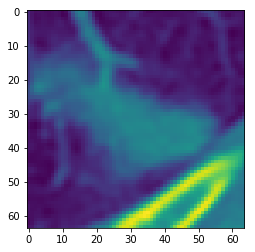

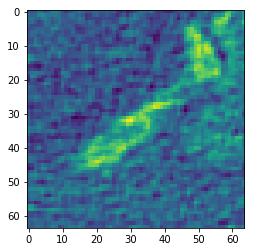

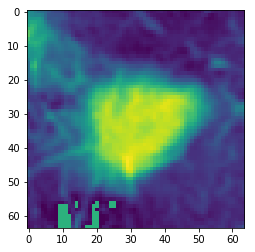

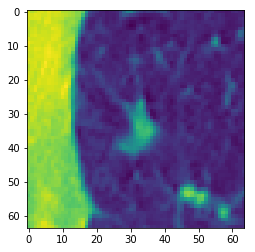

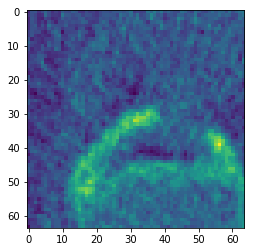

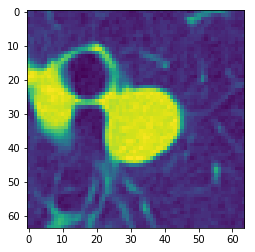

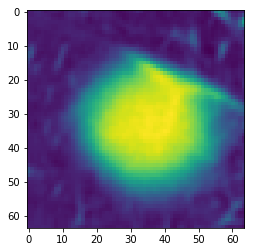

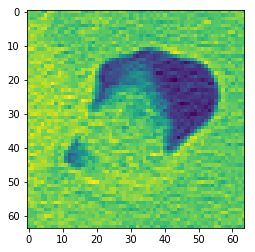

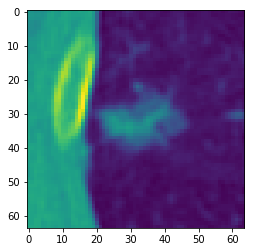

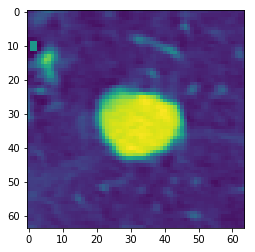

In [80]:
print("Percent labels True:", TFratio)
for i in range(10,20):
    plt.imshow(nodulecrops[i,:,:,0])
    plt.show()

## Initial CNN and Parameters

In [78]:
n_splits=5
kfold=StratifiedKFold(n_splits=n_splits, shuffle=True)
#classify as nodule or non-nodule
input_shape=(64,64,1)
num_classes=2
width=32
epochs=135
batch_size=256
cvscores=[]
cvscoresrandom=[]
history=[]
historyrandom=[]
aucscores=[]
aucscoresrandom=[]
predicted=[]
malignantlabeltest=[]
predictedrandom=[]
randomlabeltest=[]
for train,test in kfold.split(nodulecrops,malignantlabel):
    model = Sequential()
    
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.50))
    model.add(Flatten())
    model.add(Dense(width*4, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation='softmax'))
    #model.summary()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(lr=1e-5),
                  metrics=['accuracy'])
    histor=model.fit(nodulecrops[train],malignantlabelcat[train], batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(nodulecrops[test],malignantlabelcat[test]))
    scores=model.evaluate(nodulecrops[test],malignantlabelcat[test])
    cvscores.append(scores)
    predicted.append(model.predict_proba(nodulecrops[test])[:,1])
    malignantlabeltest.append([malignantlabel[i] for i in test])
    aucscores.append(roc_auc_score(malignantlabelcat[test],model.predict_proba(nodulecrops[test])))
    history.append(histor)
predicted=np.concatenate(np.array(predicted),axis=0)
malignantlabeltest=np.concatenate(np.array(malignantlabeltest),axis=0)
roc=roc_curve(malignantlabeltest,predicted)
    
for train,test in kfold.split(nodulecrops,randomlabel):
    model = Sequential()
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.50))
    model.add(Flatten())
    model.add(Dense(width*4, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(lr=2e-5),
                  metrics=['accuracy'])
    historrandom=model.fit(nodulecrops[train],randomlabelcat[train], batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(nodulecrops[test],randomlabelcat[test]))
    coresrandom=model.evaluate(nodulecrops[test],randomlabelcat[test])
    cvscoresrandom.append(coresrandom)
    aucscoresrandom.append(roc_auc_score(randomlabelcat[test],model.predict_proba(nodulecrops[test])))
    historyrandom.append(historrandom)
    predictedrandom.append(model.predict_proba(nodulecrops[test])[:,1])
    randomlabeltest.append(randomlabel[test])
predictedrandom=np.concatenate(np.array(predictedrandom),axis=0)
randomlabeltest=np.concatenate(np.array(randomlabeltest),axis=0)
rocrandom=roc_curve(randomlabeltest,predictedrandom)

Train on 1264 samples, validate on 317 samples
Epoch 1/135
1264/1264 [==============================] - 2s - loss: 0.6892 - acc: 0.5570 - val_loss: 0.6483 - val_acc: 0.7003
Epoch 2/135
1264/1264 [==============================] - 0s - loss: 0.6323 - acc: 0.6820 - val_loss: 0.6086 - val_acc: 0.7350
Epoch 3/135
1264/1264 [==============================] - 0s - loss: 0.6040 - acc: 0.7263 - val_loss: 0.5908 - val_acc: 0.7350
Epoch 4/135
1264/1264 [==============================] - 0s - loss: 0.5988 - acc: 0.7334 - val_loss: 0.5855 - val_acc: 0.7350
Epoch 5/135
1264/1264 [==============================] - 0s - loss: 0.5965 - acc: 0.7342 - val_loss: 0.5847 - val_acc: 0.7350
Epoch 6/135
1264/1264 [==============================] - 0s - loss: 0.5990 - acc: 0.7342 - val_loss: 0.5842 - val_acc: 0.7350
Epoch 7/135
1264/1264 [==============================] - 0s - loss: 0.5926 - acc: 0.7334 - val_loss: 0.5833 - val_acc: 0.7350
Epoch 8/135
1264/1264 [==============================] - 0s - loss: 0.5

1264/1264 [==============================] - 0s - loss: 0.5510 - acc: 0.7381 - val_loss: 0.5699 - val_acc: 0.7350
Epoch 66/135
1264/1264 [==============================] - 0s - loss: 0.5630 - acc: 0.7397 - val_loss: 0.5697 - val_acc: 0.7350
Epoch 67/135
1264/1264 [==============================] - 0s - loss: 0.5500 - acc: 0.7373 - val_loss: 0.5698 - val_acc: 0.7350
Epoch 68/135
1264/1264 [==============================] - 0s - loss: 0.5557 - acc: 0.7413 - val_loss: 0.5698 - val_acc: 0.7350
Epoch 69/135
1264/1264 [==============================] - 0s - loss: 0.5530 - acc: 0.7373 - val_loss: 0.5697 - val_acc: 0.7413
Epoch 70/135
1264/1264 [==============================] - 0s - loss: 0.5577 - acc: 0.7389 - val_loss: 0.5696 - val_acc: 0.7413
Epoch 71/135
1264/1264 [==============================] - 0s - loss: 0.5531 - acc: 0.7421 - val_loss: 0.5695 - val_acc: 0.7382
Epoch 72/135
1264/1264 [==============================] - 0s - loss: 0.5484 - acc: 0.7437 - val_loss: 0.5692 - val_acc: 0.73

1264/1264 [==============================] - 0s - loss: 0.5283 - acc: 0.7508 - val_loss: 0.5637 - val_acc: 0.7319
Epoch 130/135
1264/1264 [==============================] - 0s - loss: 0.5376 - acc: 0.7421 - val_loss: 0.5637 - val_acc: 0.7319
Epoch 131/135
1264/1264 [==============================] - 0s - loss: 0.5271 - acc: 0.7595 - val_loss: 0.5633 - val_acc: 0.7319
Epoch 132/135
1264/1264 [==============================] - 0s - loss: 0.5254 - acc: 0.7587 - val_loss: 0.5634 - val_acc: 0.7319
Epoch 133/135
1264/1264 [==============================] - 0s - loss: 0.5243 - acc: 0.7619 - val_loss: 0.5634 - val_acc: 0.7319
Epoch 134/135
1264/1264 [==============================] - 0s - loss: 0.5256 - acc: 0.7532 - val_loss: 0.5636 - val_acc: 0.7319
Epoch 135/135
 32/317 [==>...........................] - ETA: 0ssTrain on 1265 samples, validate on 316 samples
Epoch 1/135
1265/1265 [==============================] - 2s - loss: 0.7065 - acc: 0.4964 - val_loss: 0.6510 - val_acc: 0.7184
Epoch 2/

1265/1265 [==============================] - 0s - loss: 0.5603 - acc: 0.7336 - val_loss: 0.5620 - val_acc: 0.7342
Epoch 58/135
1265/1265 [==============================] - 0s - loss: 0.5633 - acc: 0.7336 - val_loss: 0.5620 - val_acc: 0.7342
Epoch 59/135
1265/1265 [==============================] - 0s - loss: 0.5600 - acc: 0.7320 - val_loss: 0.5618 - val_acc: 0.7342
Epoch 60/135
1265/1265 [==============================] - 0s - loss: 0.5647 - acc: 0.7375 - val_loss: 0.5616 - val_acc: 0.7342
Epoch 61/135
1265/1265 [==============================] - 0s - loss: 0.5587 - acc: 0.7360 - val_loss: 0.5612 - val_acc: 0.7342
Epoch 62/135
1265/1265 [==============================] - 0s - loss: 0.5590 - acc: 0.7336 - val_loss: 0.5610 - val_acc: 0.7342
Epoch 63/135
1265/1265 [==============================] - 0s - loss: 0.5538 - acc: 0.7360 - val_loss: 0.5609 - val_acc: 0.7342
Epoch 64/135
1265/1265 [==============================] - 0s - loss: 0.5629 - acc: 0.7328 - val_loss: 0.5609 - val_acc: 0.73

1265/1265 [==============================] - 0s - loss: 0.5379 - acc: 0.7526 - val_loss: 0.5600 - val_acc: 0.7373
Epoch 122/135
1265/1265 [==============================] - 0s - loss: 0.5368 - acc: 0.7462 - val_loss: 0.5602 - val_acc: 0.7373
Epoch 123/135
1265/1265 [==============================] - 0s - loss: 0.5332 - acc: 0.7518 - val_loss: 0.5602 - val_acc: 0.7373
Epoch 124/135
1265/1265 [==============================] - 0s - loss: 0.5422 - acc: 0.7470 - val_loss: 0.5603 - val_acc: 0.7373
Epoch 125/135
1265/1265 [==============================] - 0s - loss: 0.5382 - acc: 0.7510 - val_loss: 0.5604 - val_acc: 0.7373
Epoch 126/135
1265/1265 [==============================] - 0s - loss: 0.5331 - acc: 0.7573 - val_loss: 0.5603 - val_acc: 0.7342
Epoch 127/135
1265/1265 [==============================] - 0s - loss: 0.5325 - acc: 0.7470 - val_loss: 0.5602 - val_acc: 0.7342
Epoch 128/135
1265/1265 [==============================] - 0s - loss: 0.5288 - acc: 0.7526 - val_loss: 0.5601 - val_ac

1265/1265 [==============================] - 0s - loss: 0.5575 - acc: 0.7344 - val_loss: 0.5720 - val_acc: 0.7342
Epoch 50/135
1265/1265 [==============================] - 0s - loss: 0.5678 - acc: 0.7391 - val_loss: 0.5718 - val_acc: 0.7342
Epoch 51/135
1265/1265 [==============================] - 0s - loss: 0.5646 - acc: 0.7423 - val_loss: 0.5719 - val_acc: 0.7342
Epoch 52/135
1265/1265 [==============================] - 0s - loss: 0.5613 - acc: 0.7375 - val_loss: 0.5715 - val_acc: 0.7342
Epoch 53/135
1265/1265 [==============================] - 0s - loss: 0.5631 - acc: 0.7383 - val_loss: 0.5712 - val_acc: 0.7342
Epoch 54/135
1265/1265 [==============================] - 0s - loss: 0.5596 - acc: 0.7360 - val_loss: 0.5710 - val_acc: 0.7342
Epoch 55/135
1265/1265 [==============================] - 0s - loss: 0.5620 - acc: 0.7407 - val_loss: 0.5706 - val_acc: 0.7342
Epoch 56/135
1265/1265 [==============================] - 0s - loss: 0.5600 - acc: 0.7391 - val_loss: 0.5705 - val_acc: 0.73

1265/1265 [==============================] - 0s - loss: 0.5295 - acc: 0.7565 - val_loss: 0.5611 - val_acc: 0.7342
Epoch 114/135
1265/1265 [==============================] - 0s - loss: 0.5375 - acc: 0.7565 - val_loss: 0.5609 - val_acc: 0.7342
Epoch 115/135
1265/1265 [==============================] - 0s - loss: 0.5337 - acc: 0.7494 - val_loss: 0.5608 - val_acc: 0.7342
Epoch 116/135
1265/1265 [==============================] - 0s - loss: 0.5278 - acc: 0.7549 - val_loss: 0.5608 - val_acc: 0.7342
Epoch 117/135
1265/1265 [==============================] - 0s - loss: 0.5329 - acc: 0.7549 - val_loss: 0.5608 - val_acc: 0.7342
Epoch 118/135
1265/1265 [==============================] - 0s - loss: 0.5279 - acc: 0.7565 - val_loss: 0.5605 - val_acc: 0.7342
Epoch 119/135
1265/1265 [==============================] - 0s - loss: 0.5336 - acc: 0.7581 - val_loss: 0.5604 - val_acc: 0.7342
Epoch 120/135
1265/1265 [==============================] - 0s - loss: 0.5294 - acc: 0.7573 - val_loss: 0.5604 - val_ac

1265/1265 [==============================] - 0s - loss: 0.5668 - acc: 0.7352 - val_loss: 0.5695 - val_acc: 0.7342
Epoch 42/135
1265/1265 [==============================] - 0s - loss: 0.5733 - acc: 0.7304 - val_loss: 0.5694 - val_acc: 0.7342
Epoch 43/135
1265/1265 [==============================] - 0s - loss: 0.5731 - acc: 0.7328 - val_loss: 0.5691 - val_acc: 0.7342
Epoch 44/135
1265/1265 [==============================] - 0s - loss: 0.5698 - acc: 0.7360 - val_loss: 0.5688 - val_acc: 0.7342
Epoch 45/135
1265/1265 [==============================] - 0s - loss: 0.5746 - acc: 0.7360 - val_loss: 0.5687 - val_acc: 0.7342
Epoch 46/135
1265/1265 [==============================] - 0s - loss: 0.5746 - acc: 0.7344 - val_loss: 0.5686 - val_acc: 0.7342
Epoch 47/135
1265/1265 [==============================] - 0s - loss: 0.5664 - acc: 0.7352 - val_loss: 0.5685 - val_acc: 0.7342
Epoch 48/135
1265/1265 [==============================] - 0s - loss: 0.5714 - acc: 0.7344 - val_loss: 0.5684 - val_acc: 0.73

1265/1265 [==============================] - 0s - loss: 0.5493 - acc: 0.7375 - val_loss: 0.5642 - val_acc: 0.7342
Epoch 106/135
1265/1265 [==============================] - 0s - loss: 0.5488 - acc: 0.7439 - val_loss: 0.5643 - val_acc: 0.7342
Epoch 107/135
1265/1265 [==============================] - 0s - loss: 0.5427 - acc: 0.7431 - val_loss: 0.5642 - val_acc: 0.7342
Epoch 108/135
1265/1265 [==============================] - 0s - loss: 0.5448 - acc: 0.7360 - val_loss: 0.5642 - val_acc: 0.7342
Epoch 109/135
1265/1265 [==============================] - 0s - loss: 0.5540 - acc: 0.7344 - val_loss: 0.5643 - val_acc: 0.7373
Epoch 110/135
1265/1265 [==============================] - 0s - loss: 0.5523 - acc: 0.7399 - val_loss: 0.5643 - val_acc: 0.7373
Epoch 111/135
1265/1265 [==============================] - 0s - loss: 0.5469 - acc: 0.7431 - val_loss: 0.5644 - val_acc: 0.7373
Epoch 112/135
1265/1265 [==============================] - 0s - loss: 0.5427 - acc: 0.7439 - val_loss: 0.5641 - val_ac

1265/1265 [==============================] - 0s - loss: 0.5665 - acc: 0.7352 - val_loss: 0.5825 - val_acc: 0.7342
Epoch 34/135
1265/1265 [==============================] - 0s - loss: 0.5696 - acc: 0.7344 - val_loss: 0.5824 - val_acc: 0.7342
Epoch 35/135
1265/1265 [==============================] - 0s - loss: 0.5662 - acc: 0.7336 - val_loss: 0.5824 - val_acc: 0.7342
Epoch 36/135
1265/1265 [==============================] - 0s - loss: 0.5703 - acc: 0.7344 - val_loss: 0.5823 - val_acc: 0.7342
Epoch 37/135
1265/1265 [==============================] - 0s - loss: 0.5725 - acc: 0.7344 - val_loss: 0.5822 - val_acc: 0.7342
Epoch 38/135
1265/1265 [==============================] - 0s - loss: 0.5677 - acc: 0.7360 - val_loss: 0.5821 - val_acc: 0.7342
Epoch 39/135
1265/1265 [==============================] - 0s - loss: 0.5615 - acc: 0.7352 - val_loss: 0.5820 - val_acc: 0.7342
Epoch 40/135
1265/1265 [==============================] - 0s - loss: 0.5673 - acc: 0.7352 - val_loss: 0.5820 - val_acc: 0.73

1265/1265 [==============================] - 0s - loss: 0.5424 - acc: 0.7439 - val_loss: 0.5884 - val_acc: 0.7278
Epoch 98/135
1265/1265 [==============================] - 0s - loss: 0.5350 - acc: 0.7518 - val_loss: 0.5885 - val_acc: 0.7278
Epoch 99/135
1265/1265 [==============================] - 0s - loss: 0.5402 - acc: 0.7455 - val_loss: 0.5885 - val_acc: 0.7278
Epoch 100/135
1265/1265 [==============================] - 0s - loss: 0.5358 - acc: 0.7470 - val_loss: 0.5886 - val_acc: 0.7215
Epoch 101/135
1265/1265 [==============================] - 0s - loss: 0.5361 - acc: 0.7494 - val_loss: 0.5887 - val_acc: 0.7247
Epoch 102/135
1265/1265 [==============================] - 0s - loss: 0.5356 - acc: 0.7542 - val_loss: 0.5891 - val_acc: 0.7247
Epoch 103/135
1265/1265 [==============================] - 0s - loss: 0.5345 - acc: 0.7478 - val_loss: 0.5896 - val_acc: 0.7215
Epoch 104/135
1265/1265 [==============================] - 0s - loss: 0.5351 - acc: 0.7502 - val_loss: 0.5899 - val_acc:

1264/1264 [==============================] - 0s - loss: 0.5789 - acc: 0.7437 - val_loss: 0.5774 - val_acc: 0.7445
Epoch 26/135
1264/1264 [==============================] - 0s - loss: 0.5768 - acc: 0.7445 - val_loss: 0.5774 - val_acc: 0.7445
Epoch 27/135
1264/1264 [==============================] - 0s - loss: 0.5671 - acc: 0.7437 - val_loss: 0.5774 - val_acc: 0.7445
Epoch 28/135
1264/1264 [==============================] - 0s - loss: 0.5695 - acc: 0.7437 - val_loss: 0.5768 - val_acc: 0.7445
Epoch 29/135
1264/1264 [==============================] - 0s - loss: 0.5743 - acc: 0.7429 - val_loss: 0.5769 - val_acc: 0.7445
Epoch 30/135
1264/1264 [==============================] - 0s - loss: 0.5759 - acc: 0.7445 - val_loss: 0.5772 - val_acc: 0.7445
Epoch 31/135
1264/1264 [==============================] - 0s - loss: 0.5690 - acc: 0.7437 - val_loss: 0.5774 - val_acc: 0.7445
Epoch 32/135
1264/1264 [==============================] - 0s - loss: 0.5685 - acc: 0.7453 - val_loss: 0.5780 - val_acc: 0.74

1264/1264 [==============================] - 0s - loss: 0.5489 - acc: 0.7476 - val_loss: 0.5749 - val_acc: 0.7445
Epoch 90/135
1264/1264 [==============================] - 0s - loss: 0.5590 - acc: 0.7445 - val_loss: 0.5749 - val_acc: 0.7445
Epoch 91/135
1264/1264 [==============================] - 0s - loss: 0.5467 - acc: 0.7445 - val_loss: 0.5750 - val_acc: 0.7445
Epoch 92/135
1264/1264 [==============================] - 0s - loss: 0.5524 - acc: 0.7476 - val_loss: 0.5747 - val_acc: 0.7445
Epoch 93/135
1264/1264 [==============================] - 0s - loss: 0.5475 - acc: 0.7453 - val_loss: 0.5745 - val_acc: 0.7445
Epoch 94/135
1264/1264 [==============================] - 0s - loss: 0.5571 - acc: 0.7445 - val_loss: 0.5742 - val_acc: 0.7445
Epoch 95/135
1264/1264 [==============================] - 0s - loss: 0.5502 - acc: 0.7445 - val_loss: 0.5743 - val_acc: 0.7445
Epoch 96/135
1264/1264 [==============================] - 0s - loss: 0.5544 - acc: 0.7445 - val_loss: 0.5744 - val_acc: 0.74

1264/1264 [==============================] - 0s - loss: 0.5689 - acc: 0.7445 - val_loss: 0.5829 - val_acc: 0.7445
Epoch 18/135
1264/1264 [==============================] - 0s - loss: 0.5743 - acc: 0.7453 - val_loss: 0.5833 - val_acc: 0.7445
Epoch 19/135
1264/1264 [==============================] - 0s - loss: 0.5707 - acc: 0.7445 - val_loss: 0.5833 - val_acc: 0.7445
Epoch 20/135
1264/1264 [==============================] - 0s - loss: 0.5636 - acc: 0.7445 - val_loss: 0.5834 - val_acc: 0.7445
Epoch 21/135
1264/1264 [==============================] - 0s - loss: 0.5630 - acc: 0.7445 - val_loss: 0.5835 - val_acc: 0.7445
Epoch 22/135
1264/1264 [==============================] - 0s - loss: 0.5698 - acc: 0.7445 - val_loss: 0.5835 - val_acc: 0.7445
Epoch 23/135
1264/1264 [==============================] - 0s - loss: 0.5734 - acc: 0.7445 - val_loss: 0.5838 - val_acc: 0.7445
Epoch 24/135
1264/1264 [==============================] - 0s - loss: 0.5662 - acc: 0.7445 - val_loss: 0.5840 - val_acc: 0.74

1264/1264 [==============================] - 0s - loss: 0.5349 - acc: 0.7445 - val_loss: 0.5943 - val_acc: 0.7445
Epoch 82/135
1264/1264 [==============================] - 0s - loss: 0.5333 - acc: 0.7460 - val_loss: 0.5947 - val_acc: 0.7445
Epoch 83/135
1264/1264 [==============================] - 0s - loss: 0.5360 - acc: 0.7468 - val_loss: 0.5950 - val_acc: 0.7445
Epoch 84/135
1264/1264 [==============================] - 0s - loss: 0.5393 - acc: 0.7468 - val_loss: 0.5951 - val_acc: 0.7445
Epoch 85/135
1264/1264 [==============================] - 0s - loss: 0.5348 - acc: 0.7460 - val_loss: 0.5953 - val_acc: 0.7445
Epoch 86/135
1264/1264 [==============================] - 0s - loss: 0.5318 - acc: 0.7468 - val_loss: 0.5957 - val_acc: 0.7445
Epoch 87/135
1264/1264 [==============================] - 0s - loss: 0.5389 - acc: 0.7476 - val_loss: 0.5958 - val_acc: 0.7445
Epoch 88/135
1264/1264 [==============================] - 0s - loss: 0.5325 - acc: 0.7492 - val_loss: 0.5959 - val_acc: 0.74

1265/1265 [==============================] - 0s - loss: 0.5751 - acc: 0.7447 - val_loss: 0.5775 - val_acc: 0.7437
Epoch 10/135
1265/1265 [==============================] - 0s - loss: 0.5764 - acc: 0.7447 - val_loss: 0.5770 - val_acc: 0.7437
Epoch 11/135
1265/1265 [==============================] - 0s - loss: 0.5744 - acc: 0.7439 - val_loss: 0.5764 - val_acc: 0.7437
Epoch 12/135
1265/1265 [==============================] - 0s - loss: 0.5770 - acc: 0.7447 - val_loss: 0.5759 - val_acc: 0.7437
Epoch 13/135
1265/1265 [==============================] - 0s - loss: 0.5775 - acc: 0.7447 - val_loss: 0.5756 - val_acc: 0.7437
Epoch 14/135
1265/1265 [==============================] - 0s - loss: 0.5764 - acc: 0.7455 - val_loss: 0.5755 - val_acc: 0.7437
Epoch 15/135
1265/1265 [==============================] - 0s - loss: 0.5745 - acc: 0.7447 - val_loss: 0.5753 - val_acc: 0.7437
Epoch 16/135
1265/1265 [==============================] - 0s - loss: 0.5798 - acc: 0.7455 - val_loss: 0.5752 - val_acc: 0.74

1265/1265 [==============================] - 0s - loss: 0.5517 - acc: 0.7455 - val_loss: 0.5829 - val_acc: 0.7437
Epoch 74/135
1265/1265 [==============================] - 0s - loss: 0.5466 - acc: 0.7462 - val_loss: 0.5833 - val_acc: 0.7437
Epoch 75/135
1265/1265 [==============================] - 0s - loss: 0.5440 - acc: 0.7455 - val_loss: 0.5835 - val_acc: 0.7437
Epoch 76/135
1265/1265 [==============================] - 0s - loss: 0.5419 - acc: 0.7455 - val_loss: 0.5840 - val_acc: 0.7437
Epoch 77/135
1265/1265 [==============================] - 0s - loss: 0.5525 - acc: 0.7455 - val_loss: 0.5838 - val_acc: 0.7437
Epoch 78/135
1265/1265 [==============================] - 0s - loss: 0.5378 - acc: 0.7470 - val_loss: 0.5833 - val_acc: 0.7437
Epoch 79/135
1265/1265 [==============================] - 0s - loss: 0.5413 - acc: 0.7478 - val_loss: 0.5840 - val_acc: 0.7437
Epoch 80/135
1265/1265 [==============================] - 0s - loss: 0.5375 - acc: 0.7439 - val_loss: 0.5854 - val_acc: 0.74

1265/1265 [==============================] - 2s - loss: 0.6344 - acc: 0.6704 - val_loss: 0.5802 - val_acc: 0.7437
Epoch 2/135
1265/1265 [==============================] - 0s - loss: 0.5936 - acc: 0.7399 - val_loss: 0.5770 - val_acc: 0.7437
Epoch 3/135
1265/1265 [==============================] - 0s - loss: 0.6016 - acc: 0.7447 - val_loss: 0.5795 - val_acc: 0.7437
Epoch 4/135
1265/1265 [==============================] - 0s - loss: 0.6022 - acc: 0.7439 - val_loss: 0.5731 - val_acc: 0.7437
Epoch 5/135
1265/1265 [==============================] - 0s - loss: 0.5898 - acc: 0.7447 - val_loss: 0.5693 - val_acc: 0.7437
Epoch 6/135
1265/1265 [==============================] - 0s - loss: 0.5868 - acc: 0.7439 - val_loss: 0.5685 - val_acc: 0.7437
Epoch 7/135
1265/1265 [==============================] - 0s - loss: 0.5845 - acc: 0.7407 - val_loss: 0.5682 - val_acc: 0.7437
Epoch 8/135
1265/1265 [==============================] - 0s - loss: 0.5807 - acc: 0.7439 - val_loss: 0.5675 - val_acc: 0.7437
Epoc

1265/1265 [==============================] - 0s - loss: 0.5588 - acc: 0.7455 - val_loss: 0.5718 - val_acc: 0.7437
Epoch 66/135
1265/1265 [==============================] - 0s - loss: 0.5476 - acc: 0.7439 - val_loss: 0.5722 - val_acc: 0.7437
Epoch 67/135
1265/1265 [==============================] - 0s - loss: 0.5579 - acc: 0.7447 - val_loss: 0.5726 - val_acc: 0.7437
Epoch 68/135
1265/1265 [==============================] - 0s - loss: 0.5516 - acc: 0.7447 - val_loss: 0.5720 - val_acc: 0.7437
Epoch 69/135
1265/1265 [==============================] - 0s - loss: 0.5495 - acc: 0.7470 - val_loss: 0.5720 - val_acc: 0.7437
Epoch 70/135
1265/1265 [==============================] - 0s - loss: 0.5561 - acc: 0.7423 - val_loss: 0.5723 - val_acc: 0.7437
Epoch 71/135
1265/1265 [==============================] - 0s - loss: 0.5521 - acc: 0.7470 - val_loss: 0.5728 - val_acc: 0.7437
Epoch 72/135
1265/1265 [==============================] - 0s - loss: 0.5467 - acc: 0.7470 - val_loss: 0.5732 - val_acc: 0.74

1265/1265 [==============================] - 0s - loss: 0.5188 - acc: 0.7534 - val_loss: 0.5866 - val_acc: 0.7405
Epoch 130/135
1265/1265 [==============================] - 0s - loss: 0.5002 - acc: 0.7621 - val_loss: 0.5872 - val_acc: 0.7405
Epoch 131/135
1265/1265 [==============================] - 0s - loss: 0.5063 - acc: 0.7573 - val_loss: 0.5880 - val_acc: 0.7405
Epoch 132/135
1265/1265 [==============================] - 0s - loss: 0.5135 - acc: 0.7573 - val_loss: 0.5879 - val_acc: 0.7405
Epoch 133/135
1265/1265 [==============================] - 0s - loss: 0.5159 - acc: 0.7542 - val_loss: 0.5879 - val_acc: 0.7405
Epoch 134/135
1265/1265 [==============================] - 0s - loss: 0.5091 - acc: 0.7621 - val_loss: 0.5879 - val_acc: 0.7405
Epoch 135/135
 32/316 [==>...........................] - ETA: 0ssTrain on 1266 samples, validate on 315 samples
Epoch 1/135
1266/1266 [==============================] - 2s - loss: 0.6732 - acc: 0.5821 - val_loss: 0.6029 - val_acc: 0.7460
Epoch 2/

1266/1266 [==============================] - 0s - loss: 0.5584 - acc: 0.7441 - val_loss: 0.5838 - val_acc: 0.7460
Epoch 58/135
1266/1266 [==============================] - 0s - loss: 0.5543 - acc: 0.7449 - val_loss: 0.5840 - val_acc: 0.7460
Epoch 59/135
1266/1266 [==============================] - 0s - loss: 0.5575 - acc: 0.7441 - val_loss: 0.5842 - val_acc: 0.7460
Epoch 60/135
1266/1266 [==============================] - 0s - loss: 0.5570 - acc: 0.7441 - val_loss: 0.5843 - val_acc: 0.7460
Epoch 61/135
1266/1266 [==============================] - 0s - loss: 0.5515 - acc: 0.7425 - val_loss: 0.5846 - val_acc: 0.7460
Epoch 62/135
1266/1266 [==============================] - 0s - loss: 0.5550 - acc: 0.7441 - val_loss: 0.5850 - val_acc: 0.7460
Epoch 63/135
1266/1266 [==============================] - 0s - loss: 0.5550 - acc: 0.7433 - val_loss: 0.5855 - val_acc: 0.7460
Epoch 64/135
1266/1266 [==============================] - 0s - loss: 0.5521 - acc: 0.7441 - val_loss: 0.5861 - val_acc: 0.74

1266/1266 [==============================] - 0s - loss: 0.5155 - acc: 0.7551 - val_loss: 0.6066 - val_acc: 0.7397
Epoch 122/135
1266/1266 [==============================] - 0s - loss: 0.5205 - acc: 0.7559 - val_loss: 0.6071 - val_acc: 0.7397
Epoch 123/135
1266/1266 [==============================] - 0s - loss: 0.5162 - acc: 0.7622 - val_loss: 0.6072 - val_acc: 0.7397
Epoch 124/135
1266/1266 [==============================] - 0s - loss: 0.5163 - acc: 0.7575 - val_loss: 0.6081 - val_acc: 0.7397
Epoch 125/135
1266/1266 [==============================] - 0s - loss: 0.5077 - acc: 0.7520 - val_loss: 0.6090 - val_acc: 0.7397
Epoch 126/135
1266/1266 [==============================] - 0s - loss: 0.5101 - acc: 0.7559 - val_loss: 0.6097 - val_acc: 0.7397
Epoch 127/135
1266/1266 [==============================] - 0s - loss: 0.5119 - acc: 0.7528 - val_loss: 0.6094 - val_acc: 0.7397
Epoch 128/135
1266/1266 [==============================] - 0s - loss: 0.5091 - acc: 0.7607 - val_loss: 0.6089 - val_ac

Mean loss across all CV sets with true labels: 0.568389013583
Mean loss across all CV sets with random labels: 0.636227802017
Mean accuracy across all CV sets with true labels: 0.739410216015
Mean accuracy across all CV sets with random labels: 0.722336503171
Lowest val_loss of 0.564570076191 at epoch [126] with true labels
Lowest val_loss of 0.576504066628 at epoch [1] with random labels
Average AUC across CV sets with true labels: 0.623053044198
Average AUC across CV sets with random labels: 0.465063403498


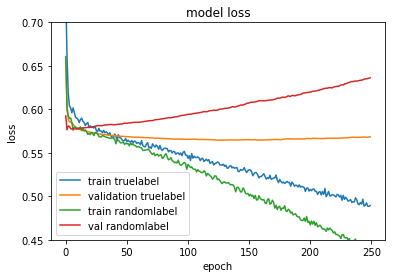

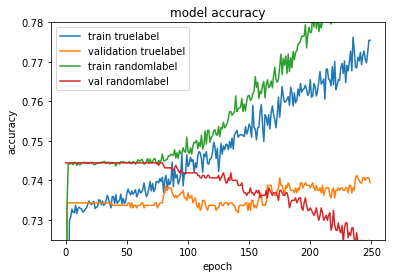

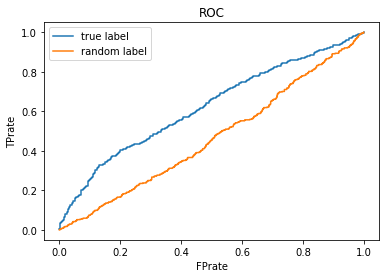

In [77]:
print("Mean loss across all CV sets with true labels:", np.mean([cvscores[i][0] for i in range(len(cvscores))]))
print("Mean loss across all CV sets with random labels:", np.mean([cvscoresrandom[i][0] for i in range(len(cvscoresrandom))]))
print("Mean accuracy across all CV sets with true labels:", np.mean([cvscores[i][1] for i in range(len(cvscores))]))
print("Mean accuracy across all CV sets with random labels:", np.mean([cvscoresrandom[i][1] for i in range(len(cvscoresrandom))]))

print("Lowest val_loss of", min(np.mean([history[i].history['val_loss'] for i in range(n_splits)],axis=0)), "at epoch", np.where(np.mean([history[i].history['val_loss'] for i in range(n_splits)],axis=0)==min(np.mean([history[i].history['val_loss'] for i in range(n_splits)],axis=0)))[0], "with true labels")
print("Lowest val_loss of", min(np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)],axis=0)), "at epoch", np.where(np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)],axis=0)==min(np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)],axis=0)))[0],"with random labels")
print("Average AUC across CV sets with true labels:",np.mean(aucscores))
print("Average AUC across CV sets with random labels:",np.mean(aucscoresrandom))
acc=np.mean([history[i].history['acc'] for i in range(n_splits)], axis=0)
valacc=np.mean([history[i].history['val_acc'] for i in range(n_splits)], axis=0)
loss=np.mean([history[i].history['loss'] for i in range(n_splits)], axis=0)
valloss=np.mean([history[i].history['val_loss'] for i in range(n_splits)], axis=0)
randacc=np.mean([historyrandom[i].history['acc'] for i in range(n_splits)], axis=0)
randvalacc=np.mean([historyrandom[i].history['val_acc'] for i in range(n_splits)], axis=0)
randloss=np.mean([historyrandom[i].history['loss'] for i in range(n_splits)], axis=0)
randvalloss=np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)], axis=0)

# summarize history for loss
plt.plot(loss)
plt.plot(valloss)
plt.plot(randloss)
plt.plot(randvalloss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train truelabel', 'validation truelabel', 'train randomlabel', 'val randomlabel'], loc='best')
plt.ylim([0.45,0.7])
plt.show()



# summarize history for accuracy
plt.plot(acc)
plt.plot(valacc)
plt.plot(randacc)
plt.plot(randvalacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train truelabel', 'validation truelabel', 'train randomlabel', 'val randomlabel'], loc='best')
plt.ylim([0.725,0.78])
plt.show()

#ROC curve
plt.plot(roc[0],roc[1])
plt.plot(rocrandom[0],rocrandom[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.legend(['true label', 'random label'])
plt.show()

## Increased dropout rate to 0.75

In [11]:
n_splits=5
kfold=StratifiedKFold(n_splits=n_splits, shuffle=True)
#classify as nodule or non-nodule
input_shape=(64,64,1)
num_classes=2
width=16
epochs=30
batch_size=5
cvscores=[]
cvscoresrandom=[]
history=[]
historyrandom=[]
for train,test in kfold.split(nodulecrops,malignantlabel):
    model = Sequential()
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    #model.add(BatchNormalization(axis=1))
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    #model.add(BatchNormalization(axis=1))
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75))
    model.add(Flatten())
    model.add(Dense(width*4, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(lr=1e-5),
                  metrics=['accuracy'])
    histor=model.fit(nodulecrops[train],malignantlabelcat[train], batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(nodulecrops[test],malignantlabelcat[test]))
    scores=model.evaluate(nodulecrops[test],malignantlabelcat[test])
    cvscores.append(scores)
    history.append(histor)
    
for train,test in kfold.split(nodulecrops,randomlabel):
    model = Sequential()
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    #model.add(BatchNormalization(axis=1))
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    #model.add(BatchNormalization(axis=1))
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75))
    model.add(Flatten())
    model.add(Dense(width*4, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(lr=1e-5),
                  metrics=['accuracy'])
    historrandom=model.fit(nodulecrops[train],randomlabelcat[train], batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(nodulecrops[test],randomlabelcat[test]))
    scoresrandom=model.evaluate(nodulecrops[test],randomlabelcat[test])
    cvscoresrandom.append(scoresrandom)
    historyrandom.append(historrandom)

Train on 1264 samples, validate on 317 samples
Epoch 1/30
1264/1264 [==============================] - 4s - loss: 0.6219 - acc: 0.6986 - val_loss: 0.5855 - val_acc: 0.7350
Epoch 2/30
1264/1264 [==============================] - 3s - loss: 0.5877 - acc: 0.7342 - val_loss: 0.5851 - val_acc: 0.7350
Epoch 3/30
1264/1264 [==============================] - 3s - loss: 0.5804 - acc: 0.7342 - val_loss: 0.5835 - val_acc: 0.7350
Epoch 4/30
1264/1264 [==============================] - 3s - loss: 0.5832 - acc: 0.7342 - val_loss: 0.5826 - val_acc: 0.7350
Epoch 5/30
1264/1264 [==============================] - 3s - loss: 0.5836 - acc: 0.7342 - val_loss: 0.5819 - val_acc: 0.7350
Epoch 6/30
1264/1264 [==============================] - 3s - loss: 0.5766 - acc: 0.7342 - val_loss: 0.5811 - val_acc: 0.7350
Epoch 7/30
1264/1264 [==============================] - 3s - loss: 0.5831 - acc: 0.7342 - val_loss: 0.5802 - val_acc: 0.7350
Epoch 8/30
1264/1264 [==============================] - 3s - loss: 0.5784 - ac

1265/1265 [==============================] - 3s - loss: 0.5483 - acc: 0.7407 - val_loss: 0.5905 - val_acc: 0.7310
Epoch 29/30
1265/1265 [==============================] - 3s - loss: 0.5451 - acc: 0.7415 - val_loss: 0.5899 - val_acc: 0.7310
Epoch 30/30
288/316 [==========================>...] - ETA: 0sTrain on 1265 samples, validate on 316 samples
Epoch 1/30
1265/1265 [==============================] - 4s - loss: 0.6034 - acc: 0.7170 - val_loss: 0.5738 - val_acc: 0.7342
Epoch 2/30
1265/1265 [==============================] - 3s - loss: 0.5925 - acc: 0.7344 - val_loss: 0.5724 - val_acc: 0.7342
Epoch 3/30
1265/1265 [==============================] - 3s - loss: 0.5817 - acc: 0.7344 - val_loss: 0.5708 - val_acc: 0.7342
Epoch 4/30
1265/1265 [==============================] - 3s - loss: 0.5856 - acc: 0.7344 - val_loss: 0.5706 - val_acc: 0.7342
Epoch 5/30
1265/1265 [==============================] - 3s - loss: 0.5871 - acc: 0.7344 - val_loss: 0.5692 - val_acc: 0.7342
Epoch 6/30
1265/1265 [====

1265/1265 [==============================] - 3s - loss: 0.5538 - acc: 0.7344 - val_loss: 0.5542 - val_acc: 0.7342
Epoch 27/30
1265/1265 [==============================] - 3s - loss: 0.5483 - acc: 0.7391 - val_loss: 0.5568 - val_acc: 0.7310
Epoch 28/30
1265/1265 [==============================] - 3s - loss: 0.5491 - acc: 0.7399 - val_loss: 0.5520 - val_acc: 0.7342
Epoch 29/30
1265/1265 [==============================] - 3s - loss: 0.5432 - acc: 0.7399 - val_loss: 0.5516 - val_acc: 0.7310
Epoch 30/30
288/316 [==========================>...] - ETA: 0sTrain on 1265 samples, validate on 316 samples
Epoch 1/30
1265/1265 [==============================] - 4s - loss: 0.6306 - acc: 0.6798 - val_loss: 0.5758 - val_acc: 0.7342
Epoch 2/30
1265/1265 [==============================] - 3s - loss: 0.5982 - acc: 0.7344 - val_loss: 0.5740 - val_acc: 0.7342
Epoch 3/30
1265/1265 [==============================] - 3s - loss: 0.5874 - acc: 0.7336 - val_loss: 0.5714 - val_acc: 0.7342
Epoch 4/30
1265/1265 [==

1265/1265 [==============================] - 3s - loss: 0.5539 - acc: 0.7423 - val_loss: 0.5659 - val_acc: 0.7437
Epoch 24/30
1265/1265 [==============================] - 3s - loss: 0.5462 - acc: 0.7352 - val_loss: 0.5658 - val_acc: 0.7437
Epoch 25/30
1265/1265 [==============================] - 3s - loss: 0.5407 - acc: 0.7383 - val_loss: 0.5661 - val_acc: 0.7437
Epoch 26/30
1265/1265 [==============================] - 3s - loss: 0.5387 - acc: 0.7455 - val_loss: 0.5654 - val_acc: 0.7437
Epoch 27/30
1265/1265 [==============================] - 3s - loss: 0.5395 - acc: 0.7462 - val_loss: 0.5670 - val_acc: 0.7468
Epoch 28/30
1265/1265 [==============================] - 3s - loss: 0.5499 - acc: 0.7368 - val_loss: 0.5653 - val_acc: 0.7468
Epoch 29/30
1265/1265 [==============================] - 3s - loss: 0.5342 - acc: 0.7502 - val_loss: 0.5658 - val_acc: 0.7405
Epoch 30/30
256/316 [=======================>......] - ETA: 0sTrain on 1264 samples, validate on 317 samples
Epoch 1/30
1264/1264 

1264/1264 [==============================] - 3s - loss: 0.5579 - acc: 0.7453 - val_loss: 0.5814 - val_acc: 0.7445
Epoch 22/30
1264/1264 [==============================] - 3s - loss: 0.5612 - acc: 0.7453 - val_loss: 0.5816 - val_acc: 0.7445
Epoch 23/30
1264/1264 [==============================] - 3s - loss: 0.5570 - acc: 0.7453 - val_loss: 0.5807 - val_acc: 0.7445
Epoch 24/30
1264/1264 [==============================] - 3s - loss: 0.5632 - acc: 0.7453 - val_loss: 0.5802 - val_acc: 0.7445
Epoch 25/30
1264/1264 [==============================] - 3s - loss: 0.5582 - acc: 0.7460 - val_loss: 0.5806 - val_acc: 0.7445
Epoch 26/30
1264/1264 [==============================] - 3s - loss: 0.5577 - acc: 0.7453 - val_loss: 0.5789 - val_acc: 0.7445
Epoch 27/30
1264/1264 [==============================] - 3s - loss: 0.5536 - acc: 0.7445 - val_loss: 0.5790 - val_acc: 0.7445
Epoch 28/30
1264/1264 [==============================] - 3s - loss: 0.5513 - acc: 0.7453 - val_loss: 0.5785 - val_acc: 0.7445
Epoc

1264/1264 [==============================] - 3s - loss: 0.5710 - acc: 0.7453 - val_loss: 0.5751 - val_acc: 0.7445
Epoch 22/30
1264/1264 [==============================] - 3s - loss: 0.5688 - acc: 0.7453 - val_loss: 0.5756 - val_acc: 0.7445
Epoch 23/30
1264/1264 [==============================] - 3s - loss: 0.5644 - acc: 0.7453 - val_loss: 0.5737 - val_acc: 0.7445
Epoch 24/30
1264/1264 [==============================] - 3s - loss: 0.5683 - acc: 0.7453 - val_loss: 0.5743 - val_acc: 0.7445
Epoch 25/30
1264/1264 [==============================] - 3s - loss: 0.5584 - acc: 0.7453 - val_loss: 0.5730 - val_acc: 0.7445
Epoch 26/30
1264/1264 [==============================] - 3s - loss: 0.5675 - acc: 0.7453 - val_loss: 0.5741 - val_acc: 0.7445
Epoch 27/30
1264/1264 [==============================] - 3s - loss: 0.5570 - acc: 0.7453 - val_loss: 0.5723 - val_acc: 0.7445
Epoch 28/30
1264/1264 [==============================] - 3s - loss: 0.5650 - acc: 0.7453 - val_loss: 0.5765 - val_acc: 0.7445
Epoc

1266/1266 [==============================] - 3s - loss: 0.5632 - acc: 0.7449 - val_loss: 0.5722 - val_acc: 0.7460
Epoch 20/30
1266/1266 [==============================] - 3s - loss: 0.5703 - acc: 0.7449 - val_loss: 0.5704 - val_acc: 0.7460
Epoch 21/30
1266/1266 [==============================] - 3s - loss: 0.5578 - acc: 0.7449 - val_loss: 0.5704 - val_acc: 0.7460
Epoch 22/30
1266/1266 [==============================] - 3s - loss: 0.5650 - acc: 0.7449 - val_loss: 0.5726 - val_acc: 0.7460
Epoch 23/30
1266/1266 [==============================] - 3s - loss: 0.5666 - acc: 0.7449 - val_loss: 0.5706 - val_acc: 0.7460
Epoch 24/30
1266/1266 [==============================] - 3s - loss: 0.5598 - acc: 0.7449 - val_loss: 0.5704 - val_acc: 0.7460
Epoch 25/30
1266/1266 [==============================] - 3s - loss: 0.5595 - acc: 0.7449 - val_loss: 0.5706 - val_acc: 0.7460
Epoch 26/30
1266/1266 [==============================] - 3s - loss: 0.5621 - acc: 0.7449 - val_loss: 0.5710 - val_acc: 0.7460
Epoc

Mean loss across all CV sets with true labels: 0.565945509407
Mean loss across all CV sets with random labels: 0.57571187416
Mean accuracy across all CV sets with true labels: 0.735610751248
Mean accuracy across all CV sets with random labels: 0.745100395732
Lowest val_loss of 0.565504729975 at epoch [28] with true labels
Lowest val_loss of 0.574752183049 at epoch [26] with random labels


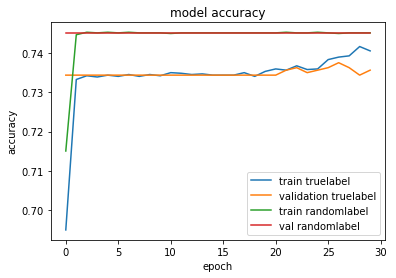

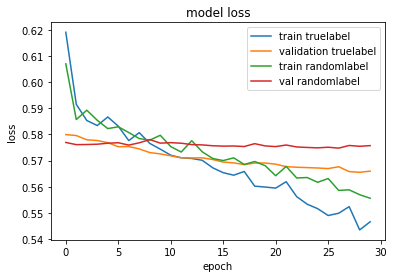

In [12]:
print("Mean loss across all CV sets with true labels:", np.mean([cvscores[i][0] for i in range(len(cvscores))]))
print("Mean loss across all CV sets with random labels:", np.mean([cvscoresrandom[i][0] for i in range(len(cvscoresrandom))]))
print("Mean accuracy across all CV sets with true labels:", np.mean([cvscores[i][1] for i in range(len(cvscores))]))
print("Mean accuracy across all CV sets with random labels:", np.mean([cvscoresrandom[i][1] for i in range(len(cvscoresrandom))]))

print("Lowest val_loss of", min(np.mean([history[i].history['val_loss'] for i in range(n_splits)],axis=0)), "at epoch", np.where(np.mean([history[i].history['val_loss'] for i in range(n_splits)],axis=0)==min(np.mean([history[i].history['val_loss'] for i in range(n_splits)],axis=0)))[0], "with true labels")
print("Lowest val_loss of", min(np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)],axis=0)), "at epoch", np.where(np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)],axis=0)==min(np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)],axis=0)))[0],"with random labels")
acc=np.mean([history[i].history['acc'] for i in range(n_splits)], axis=0)
valacc=np.mean([history[i].history['val_acc'] for i in range(n_splits)], axis=0)
loss=np.mean([history[i].history['loss'] for i in range(n_splits)], axis=0)
valloss=np.mean([history[i].history['val_loss'] for i in range(n_splits)], axis=0)
randacc=np.mean([historyrandom[i].history['acc'] for i in range(n_splits)], axis=0)
randvalacc=np.mean([historyrandom[i].history['val_acc'] for i in range(n_splits)], axis=0)
randloss=np.mean([historyrandom[i].history['loss'] for i in range(n_splits)], axis=0)
randvalloss=np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)], axis=0)

# summarize history for accuracy
plt.plot(acc)
plt.plot(valacc)
plt.plot(randacc)
plt.plot(randvalacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train truelabel', 'validation truelabel', 'train randomlabel', 'val randomlabel'], loc='best')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(valloss)
plt.plot(randloss)
plt.plot(randvalloss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train truelabel', 'validation truelabel', 'train randomlabel', 'val randomlabel'], loc='best')
plt.show()

In [19]:
from keras import regularizers
n_splits=5
kfold=StratifiedKFold(n_splits=n_splits, shuffle=True)
#classify as nodule or non-nodule
input_shape=(64,64,1)
num_classes=2
width=16
epochs=250
batch_size=96
cvscores=[]
cvscoresrandom=[]
history=[]
historyrandom=[]
for train,test in kfold.split(nodulecrops,malignantlabel):
    model = Sequential()
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75))
    model.add(Flatten())
    model.add(Dense(width*4, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(lr=1e-5),
                  metrics=['accuracy'])
    histor=model.fit(nodulecrops[train],malignantlabelcat[train], batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(nodulecrops[test],malignantlabelcat[test]))
    scores=model.evaluate(nodulecrops[test],malignantlabelcat[test])
    cvscores.append(scores)
    history.append(histor)
    
for train,test in kfold.split(nodulecrops,randomlabel):
    model = Sequential()
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(Conv2D(width, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(Conv2D(width*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75))
    model.add(Flatten())
    model.add(Dense(width*4, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(lr=1e-5),
                  metrics=['accuracy'])
    historrandom=model.fit(nodulecrops[train],randomlabelcat[train], batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(nodulecrops[test],randomlabelcat[test]))
    scoresrandom=model.evaluate(nodulecrops[test],randomlabelcat[test])
    cvscoresrandom.append(scoresrandom)
    historyrandom.append(historrandom)

Train on 1264 samples, validate on 317 samples
Epoch 1/250
1264/1264 [==============================] - 2s - loss: 0.6817 - acc: 0.5672 - val_loss: 0.6277 - val_acc: 0.7350
Epoch 2/250
1264/1264 [==============================] - 0s - loss: 0.6180 - acc: 0.7033 - val_loss: 0.6014 - val_acc: 0.7350
Epoch 3/250
1264/1264 [==============================] - 0s - loss: 0.6105 - acc: 0.7223 - val_loss: 0.5956 - val_acc: 0.7350
Epoch 4/250
1264/1264 [==============================] - 0s - loss: 0.5932 - acc: 0.7358 - val_loss: 0.5945 - val_acc: 0.7350
Epoch 5/250
1264/1264 [==============================] - 0s - loss: 0.5911 - acc: 0.7350 - val_loss: 0.5935 - val_acc: 0.7350
Epoch 6/250
1264/1264 [==============================] - 0s - loss: 0.6022 - acc: 0.7342 - val_loss: 0.5920 - val_acc: 0.7350
Epoch 7/250
1264/1264 [==============================] - 0s - loss: 0.5918 - acc: 0.7334 - val_loss: 0.5908 - val_acc: 0.7350
Epoch 8/250
1264/1264 [==============================] - 0s - loss: 0.5

1264/1264 [==============================] - 0s - loss: 0.5219 - acc: 0.7603 - val_loss: 0.5770 - val_acc: 0.7445
Epoch 130/250
1264/1264 [==============================] - 0s - loss: 0.5181 - acc: 0.7587 - val_loss: 0.5763 - val_acc: 0.7413
Epoch 131/250
1264/1264 [==============================] - 0s - loss: 0.5268 - acc: 0.7603 - val_loss: 0.5757 - val_acc: 0.7319
Epoch 132/250
1264/1264 [==============================] - 0s - loss: 0.5314 - acc: 0.7540 - val_loss: 0.5763 - val_acc: 0.7413
Epoch 133/250
1264/1264 [==============================] - 0s - loss: 0.5158 - acc: 0.7547 - val_loss: 0.5784 - val_acc: 0.7445
Epoch 134/250
1264/1264 [==============================] - 0s - loss: 0.5102 - acc: 0.7532 - val_loss: 0.5792 - val_acc: 0.7445
Epoch 135/250
1264/1264 [==============================] - 0s - loss: 0.5183 - acc: 0.7516 - val_loss: 0.5784 - val_acc: 0.7413
Epoch 136/250
1264/1264 [==============================] - 0s - loss: 0.5199 - acc: 0.7555 - val_loss: 0.5781 - val_ac

1265/1265 [==============================] - 0s - loss: 0.5891 - acc: 0.7344 - val_loss: 0.5788 - val_acc: 0.7342
Epoch 7/250
1265/1265 [==============================] - 0s - loss: 0.5852 - acc: 0.7344 - val_loss: 0.5772 - val_acc: 0.7342
Epoch 8/250
1265/1265 [==============================] - 0s - loss: 0.5856 - acc: 0.7344 - val_loss: 0.5761 - val_acc: 0.7342
Epoch 9/250
1265/1265 [==============================] - 0s - loss: 0.5887 - acc: 0.7344 - val_loss: 0.5757 - val_acc: 0.7342
Epoch 10/250
1265/1265 [==============================] - 0s - loss: 0.5825 - acc: 0.7344 - val_loss: 0.5752 - val_acc: 0.7342
Epoch 11/250
1265/1265 [==============================] - 0s - loss: 0.5852 - acc: 0.7344 - val_loss: 0.5750 - val_acc: 0.7342
Epoch 12/250
1265/1265 [==============================] - 0s - loss: 0.5852 - acc: 0.7344 - val_loss: 0.5747 - val_acc: 0.7342
Epoch 13/250
1265/1265 [==============================] - 0s - loss: 0.5854 - acc: 0.7344 - val_loss: 0.5745 - val_acc: 0.7342


1265/1265 [==============================] - 0s - loss: 0.5230 - acc: 0.7557 - val_loss: 0.5524 - val_acc: 0.7532
Epoch 135/250
1265/1265 [==============================] - 0s - loss: 0.5317 - acc: 0.7486 - val_loss: 0.5527 - val_acc: 0.7532
Epoch 136/250
1265/1265 [==============================] - 0s - loss: 0.5282 - acc: 0.7557 - val_loss: 0.5528 - val_acc: 0.7532
Epoch 137/250
1265/1265 [==============================] - 0s - loss: 0.5268 - acc: 0.7581 - val_loss: 0.5531 - val_acc: 0.7532
Epoch 138/250
1265/1265 [==============================] - 0s - loss: 0.5289 - acc: 0.7494 - val_loss: 0.5528 - val_acc: 0.7500
Epoch 139/250
1265/1265 [==============================] - 0s - loss: 0.5265 - acc: 0.7549 - val_loss: 0.5530 - val_acc: 0.7500
Epoch 140/250
1265/1265 [==============================] - 0s - loss: 0.5273 - acc: 0.7621 - val_loss: 0.5532 - val_acc: 0.7500
Epoch 141/250
1265/1265 [==============================] - 0s - loss: 0.5246 - acc: 0.7549 - val_loss: 0.5532 - val_ac

1265/1265 [==============================] - 0s - loss: 0.5884 - acc: 0.7352 - val_loss: 0.5788 - val_acc: 0.7342
Epoch 12/250
1265/1265 [==============================] - 0s - loss: 0.5839 - acc: 0.7336 - val_loss: 0.5791 - val_acc: 0.7342
Epoch 13/250
1265/1265 [==============================] - 0s - loss: 0.5893 - acc: 0.7344 - val_loss: 0.5791 - val_acc: 0.7342
Epoch 14/250
1265/1265 [==============================] - 0s - loss: 0.5759 - acc: 0.7344 - val_loss: 0.5784 - val_acc: 0.7342
Epoch 15/250
1265/1265 [==============================] - 0s - loss: 0.5878 - acc: 0.7344 - val_loss: 0.5781 - val_acc: 0.7342
Epoch 16/250
1265/1265 [==============================] - 0s - loss: 0.5764 - acc: 0.7344 - val_loss: 0.5781 - val_acc: 0.7342
Epoch 17/250
1265/1265 [==============================] - 0s - loss: 0.5800 - acc: 0.7336 - val_loss: 0.5779 - val_acc: 0.7342
Epoch 18/250
1265/1265 [==============================] - 0s - loss: 0.5836 - acc: 0.7344 - val_loss: 0.5779 - val_acc: 0.73

1265/1265 [==============================] - 0s - loss: 0.5385 - acc: 0.7494 - val_loss: 0.5668 - val_acc: 0.7278
Epoch 140/250
1265/1265 [==============================] - 0s - loss: 0.5294 - acc: 0.7478 - val_loss: 0.5667 - val_acc: 0.7278
Epoch 141/250
1265/1265 [==============================] - 0s - loss: 0.5361 - acc: 0.7502 - val_loss: 0.5667 - val_acc: 0.7278
Epoch 142/250
1265/1265 [==============================] - 0s - loss: 0.5345 - acc: 0.7486 - val_loss: 0.5668 - val_acc: 0.7310
Epoch 143/250
1265/1265 [==============================] - 0s - loss: 0.5424 - acc: 0.7415 - val_loss: 0.5659 - val_acc: 0.7342
Epoch 144/250
1265/1265 [==============================] - 0s - loss: 0.5295 - acc: 0.7581 - val_loss: 0.5660 - val_acc: 0.7310
Epoch 145/250
1265/1265 [==============================] - 0s - loss: 0.5332 - acc: 0.7407 - val_loss: 0.5656 - val_acc: 0.7278
Epoch 146/250
1265/1265 [==============================] - 0s - loss: 0.5359 - acc: 0.7542 - val_loss: 0.5660 - val_ac

1265/1265 [==============================] - 0s - loss: 0.5805 - acc: 0.7344 - val_loss: 0.5750 - val_acc: 0.7342
Epoch 17/250
1265/1265 [==============================] - 0s - loss: 0.5823 - acc: 0.7344 - val_loss: 0.5748 - val_acc: 0.7342
Epoch 18/250
1265/1265 [==============================] - 0s - loss: 0.5852 - acc: 0.7344 - val_loss: 0.5739 - val_acc: 0.7342
Epoch 19/250
1265/1265 [==============================] - 0s - loss: 0.5901 - acc: 0.7344 - val_loss: 0.5734 - val_acc: 0.7342
Epoch 20/250
1265/1265 [==============================] - 0s - loss: 0.5786 - acc: 0.7344 - val_loss: 0.5729 - val_acc: 0.7342
Epoch 21/250
1265/1265 [==============================] - 0s - loss: 0.5798 - acc: 0.7344 - val_loss: 0.5725 - val_acc: 0.7342
Epoch 22/250
1265/1265 [==============================] - 0s - loss: 0.5797 - acc: 0.7344 - val_loss: 0.5724 - val_acc: 0.7342
Epoch 23/250
1265/1265 [==============================] - 0s - loss: 0.5810 - acc: 0.7344 - val_loss: 0.5725 - val_acc: 0.73

1265/1265 [==============================] - 0s - loss: 0.5345 - acc: 0.7431 - val_loss: 0.5563 - val_acc: 0.7437
Epoch 145/250
1265/1265 [==============================] - 0s - loss: 0.5316 - acc: 0.7407 - val_loss: 0.5568 - val_acc: 0.7437
Epoch 146/250
1265/1265 [==============================] - 0s - loss: 0.5360 - acc: 0.7368 - val_loss: 0.5567 - val_acc: 0.7437
Epoch 147/250
1265/1265 [==============================] - 0s - loss: 0.5318 - acc: 0.7542 - val_loss: 0.5568 - val_acc: 0.7563
Epoch 148/250
1265/1265 [==============================] - 0s - loss: 0.5354 - acc: 0.7510 - val_loss: 0.5570 - val_acc: 0.7563
Epoch 149/250
1265/1265 [==============================] - 0s - loss: 0.5371 - acc: 0.7549 - val_loss: 0.5567 - val_acc: 0.7532
Epoch 150/250
1265/1265 [==============================] - 0s - loss: 0.5343 - acc: 0.7526 - val_loss: 0.5566 - val_acc: 0.7468
Epoch 151/250
1265/1265 [==============================] - 0s - loss: 0.5328 - acc: 0.7470 - val_loss: 0.5566 - val_ac

1265/1265 [==============================] - 0s - loss: 0.5854 - acc: 0.7304 - val_loss: 0.5834 - val_acc: 0.7342
Epoch 22/250
1265/1265 [==============================] - 0s - loss: 0.5878 - acc: 0.7273 - val_loss: 0.5845 - val_acc: 0.7342
Epoch 23/250
1265/1265 [==============================] - 0s - loss: 0.5786 - acc: 0.7360 - val_loss: 0.5847 - val_acc: 0.7342
Epoch 24/250
1265/1265 [==============================] - 0s - loss: 0.5799 - acc: 0.7328 - val_loss: 0.5845 - val_acc: 0.7342
Epoch 25/250
1265/1265 [==============================] - 0s - loss: 0.5790 - acc: 0.7407 - val_loss: 0.5852 - val_acc: 0.7342
Epoch 26/250
1265/1265 [==============================] - 0s - loss: 0.5771 - acc: 0.7281 - val_loss: 0.5851 - val_acc: 0.7342
Epoch 27/250
1265/1265 [==============================] - 0s - loss: 0.5781 - acc: 0.7344 - val_loss: 0.5850 - val_acc: 0.7342
Epoch 28/250
1265/1265 [==============================] - 0s - loss: 0.5817 - acc: 0.7281 - val_loss: 0.5850 - val_acc: 0.73

1265/1265 [==============================] - 0s - loss: 0.5128 - acc: 0.7518 - val_loss: 0.5911 - val_acc: 0.7310
Epoch 150/250
1265/1265 [==============================] - 0s - loss: 0.5254 - acc: 0.7518 - val_loss: 0.5914 - val_acc: 0.7342
Epoch 151/250
1265/1265 [==============================] - 0s - loss: 0.5234 - acc: 0.7573 - val_loss: 0.5913 - val_acc: 0.7278
Epoch 152/250
1265/1265 [==============================] - 0s - loss: 0.5278 - acc: 0.7573 - val_loss: 0.5909 - val_acc: 0.7342
Epoch 153/250
1265/1265 [==============================] - 0s - loss: 0.5303 - acc: 0.7518 - val_loss: 0.5908 - val_acc: 0.7310
Epoch 154/250
1265/1265 [==============================] - 0s - loss: 0.5287 - acc: 0.7557 - val_loss: 0.5905 - val_acc: 0.7310
Epoch 155/250
1265/1265 [==============================] - 0s - loss: 0.5238 - acc: 0.7534 - val_loss: 0.5908 - val_acc: 0.7278
Epoch 156/250
1265/1265 [==============================] - 0s - loss: 0.5236 - acc: 0.7526 - val_loss: 0.5906 - val_ac

1264/1264 [==============================] - 0s - loss: 0.5751 - acc: 0.7453 - val_loss: 0.5768 - val_acc: 0.7445
Epoch 27/250
1264/1264 [==============================] - 0s - loss: 0.5714 - acc: 0.7453 - val_loss: 0.5770 - val_acc: 0.7445
Epoch 28/250
1264/1264 [==============================] - 0s - loss: 0.5803 - acc: 0.7453 - val_loss: 0.5768 - val_acc: 0.7445
Epoch 29/250
1264/1264 [==============================] - 0s - loss: 0.5790 - acc: 0.7453 - val_loss: 0.5769 - val_acc: 0.7445
Epoch 30/250
1264/1264 [==============================] - 0s - loss: 0.5696 - acc: 0.7453 - val_loss: 0.5772 - val_acc: 0.7445
Epoch 31/250
1264/1264 [==============================] - 0s - loss: 0.5778 - acc: 0.7453 - val_loss: 0.5772 - val_acc: 0.7445
Epoch 32/250
1264/1264 [==============================] - 0s - loss: 0.5769 - acc: 0.7453 - val_loss: 0.5772 - val_acc: 0.7445
Epoch 33/250
1264/1264 [==============================] - 0s - loss: 0.5709 - acc: 0.7453 - val_loss: 0.5770 - val_acc: 0.74

1264/1264 [==============================] - 0s - loss: 0.5363 - acc: 0.7508 - val_loss: 0.5864 - val_acc: 0.7445
Epoch 155/250
1264/1264 [==============================] - 0s - loss: 0.5380 - acc: 0.7484 - val_loss: 0.5874 - val_acc: 0.7445
Epoch 156/250
1264/1264 [==============================] - 0s - loss: 0.5346 - acc: 0.7476 - val_loss: 0.5857 - val_acc: 0.7445
Epoch 157/250
1264/1264 [==============================] - 0s - loss: 0.5318 - acc: 0.7547 - val_loss: 0.5851 - val_acc: 0.7445
Epoch 158/250
1264/1264 [==============================] - 0s - loss: 0.5320 - acc: 0.7508 - val_loss: 0.5861 - val_acc: 0.7445
Epoch 159/250
1264/1264 [==============================] - 0s - loss: 0.5286 - acc: 0.7540 - val_loss: 0.5842 - val_acc: 0.7445
Epoch 160/250
1264/1264 [==============================] - 0s - loss: 0.5310 - acc: 0.7579 - val_loss: 0.5846 - val_acc: 0.7445
Epoch 161/250
1264/1264 [==============================] - 0s - loss: 0.5224 - acc: 0.7508 - val_loss: 0.5848 - val_ac

1264/1264 [==============================] - 0s - loss: 0.5795 - acc: 0.7453 - val_loss: 0.5787 - val_acc: 0.7445
Epoch 32/250
1264/1264 [==============================] - 0s - loss: 0.5767 - acc: 0.7453 - val_loss: 0.5787 - val_acc: 0.7445
Epoch 33/250
1264/1264 [==============================] - 0s - loss: 0.5758 - acc: 0.7453 - val_loss: 0.5787 - val_acc: 0.7445
Epoch 34/250
1264/1264 [==============================] - 0s - loss: 0.5804 - acc: 0.7453 - val_loss: 0.5789 - val_acc: 0.7445
Epoch 35/250
1264/1264 [==============================] - 0s - loss: 0.5774 - acc: 0.7453 - val_loss: 0.5790 - val_acc: 0.7445
Epoch 36/250
1264/1264 [==============================] - 0s - loss: 0.5822 - acc: 0.7453 - val_loss: 0.5790 - val_acc: 0.7445
Epoch 37/250
1264/1264 [==============================] - 0s - loss: 0.5787 - acc: 0.7453 - val_loss: 0.5792 - val_acc: 0.7445
Epoch 38/250
1264/1264 [==============================] - 0s - loss: 0.5804 - acc: 0.7453 - val_loss: 0.5791 - val_acc: 0.74

1264/1264 [==============================] - 0s - loss: 0.5528 - acc: 0.7460 - val_loss: 0.5839 - val_acc: 0.7445
Epoch 160/250
1264/1264 [==============================] - 0s - loss: 0.5503 - acc: 0.7468 - val_loss: 0.5834 - val_acc: 0.7445
Epoch 161/250
1264/1264 [==============================] - 0s - loss: 0.5436 - acc: 0.7476 - val_loss: 0.5834 - val_acc: 0.7445
Epoch 162/250
1264/1264 [==============================] - 0s - loss: 0.5492 - acc: 0.7453 - val_loss: 0.5833 - val_acc: 0.7445
Epoch 163/250
1264/1264 [==============================] - 0s - loss: 0.5437 - acc: 0.7453 - val_loss: 0.5839 - val_acc: 0.7445
Epoch 164/250
1264/1264 [==============================] - 0s - loss: 0.5378 - acc: 0.7468 - val_loss: 0.5833 - val_acc: 0.7445
Epoch 165/250
1264/1264 [==============================] - 0s - loss: 0.5397 - acc: 0.7460 - val_loss: 0.5836 - val_acc: 0.7445
Epoch 166/250
1264/1264 [==============================] - 0s - loss: 0.5494 - acc: 0.7453 - val_loss: 0.5831 - val_ac

1264/1264 [==============================] - 0s - loss: 0.5761 - acc: 0.7453 - val_loss: 0.5760 - val_acc: 0.7445
Epoch 37/250
1264/1264 [==============================] - 0s - loss: 0.5783 - acc: 0.7453 - val_loss: 0.5761 - val_acc: 0.7445
Epoch 38/250
1264/1264 [==============================] - 0s - loss: 0.5825 - acc: 0.7453 - val_loss: 0.5764 - val_acc: 0.7445
Epoch 39/250
1264/1264 [==============================] - 0s - loss: 0.5732 - acc: 0.7453 - val_loss: 0.5762 - val_acc: 0.7445
Epoch 40/250
1264/1264 [==============================] - 0s - loss: 0.5796 - acc: 0.7453 - val_loss: 0.5759 - val_acc: 0.7445
Epoch 41/250
1264/1264 [==============================] - 0s - loss: 0.5739 - acc: 0.7453 - val_loss: 0.5759 - val_acc: 0.7445
Epoch 42/250
1264/1264 [==============================] - 0s - loss: 0.5732 - acc: 0.7453 - val_loss: 0.5758 - val_acc: 0.7445
Epoch 43/250
1264/1264 [==============================] - 0s - loss: 0.5718 - acc: 0.7453 - val_loss: 0.5760 - val_acc: 0.74

1264/1264 [==============================] - 0s - loss: 0.5354 - acc: 0.7540 - val_loss: 0.5707 - val_acc: 0.7445
Epoch 165/250
1264/1264 [==============================] - 0s - loss: 0.5277 - acc: 0.7508 - val_loss: 0.5709 - val_acc: 0.7445
Epoch 166/250
1264/1264 [==============================] - 0s - loss: 0.5316 - acc: 0.7468 - val_loss: 0.5702 - val_acc: 0.7445
Epoch 167/250
1264/1264 [==============================] - 0s - loss: 0.5333 - acc: 0.7524 - val_loss: 0.5703 - val_acc: 0.7445
Epoch 168/250
1264/1264 [==============================] - 0s - loss: 0.5397 - acc: 0.7524 - val_loss: 0.5705 - val_acc: 0.7445
Epoch 169/250
1264/1264 [==============================] - 0s - loss: 0.5265 - acc: 0.7532 - val_loss: 0.5706 - val_acc: 0.7445
Epoch 170/250
1264/1264 [==============================] - 0s - loss: 0.5348 - acc: 0.7508 - val_loss: 0.5713 - val_acc: 0.7445
Epoch 171/250
1264/1264 [==============================] - 0s - loss: 0.5236 - acc: 0.7524 - val_loss: 0.5716 - val_ac

1266/1266 [==============================] - 0s - loss: 0.5750 - acc: 0.7449 - val_loss: 0.5742 - val_acc: 0.7460
Epoch 42/250
1266/1266 [==============================] - 0s - loss: 0.5758 - acc: 0.7457 - val_loss: 0.5741 - val_acc: 0.7460
Epoch 43/250
1266/1266 [==============================] - 0s - loss: 0.5642 - acc: 0.7449 - val_loss: 0.5742 - val_acc: 0.7460
Epoch 44/250
1266/1266 [==============================] - 0s - loss: 0.5678 - acc: 0.7449 - val_loss: 0.5742 - val_acc: 0.7460
Epoch 45/250
1266/1266 [==============================] - 0s - loss: 0.5706 - acc: 0.7449 - val_loss: 0.5744 - val_acc: 0.7460
Epoch 46/250
1266/1266 [==============================] - 0s - loss: 0.5702 - acc: 0.7449 - val_loss: 0.5745 - val_acc: 0.7460
Epoch 47/250
1266/1266 [==============================] - 0s - loss: 0.5726 - acc: 0.7449 - val_loss: 0.5745 - val_acc: 0.7460
Epoch 48/250
1266/1266 [==============================] - 0s - loss: 0.5736 - acc: 0.7449 - val_loss: 0.5745 - val_acc: 0.74

1266/1266 [==============================] - 0s - loss: 0.5177 - acc: 0.7607 - val_loss: 0.5840 - val_acc: 0.7460
Epoch 170/250
1266/1266 [==============================] - 0s - loss: 0.5157 - acc: 0.7567 - val_loss: 0.5847 - val_acc: 0.7460
Epoch 171/250
1266/1266 [==============================] - 0s - loss: 0.5136 - acc: 0.7591 - val_loss: 0.5842 - val_acc: 0.7460
Epoch 172/250
1266/1266 [==============================] - 0s - loss: 0.5126 - acc: 0.7575 - val_loss: 0.5843 - val_acc: 0.7460
Epoch 173/250
1266/1266 [==============================] - 0s - loss: 0.5082 - acc: 0.7536 - val_loss: 0.5855 - val_acc: 0.7460
Epoch 174/250
1266/1266 [==============================] - 0s - loss: 0.5209 - acc: 0.7583 - val_loss: 0.5840 - val_acc: 0.7460
Epoch 175/250
1266/1266 [==============================] - 0s - loss: 0.5209 - acc: 0.7591 - val_loss: 0.5830 - val_acc: 0.7460
Epoch 176/250
1266/1266 [==============================] - 0s - loss: 0.5089 - acc: 0.7615 - val_loss: 0.5846 - val_ac

1266/1266 [==============================] - 0s - loss: 0.5747 - acc: 0.7449 - val_loss: 0.5721 - val_acc: 0.7460
Epoch 47/250
1266/1266 [==============================] - 0s - loss: 0.5744 - acc: 0.7449 - val_loss: 0.5725 - val_acc: 0.7460
Epoch 48/250
1266/1266 [==============================] - 0s - loss: 0.5790 - acc: 0.7449 - val_loss: 0.5720 - val_acc: 0.7460
Epoch 49/250
1266/1266 [==============================] - 0s - loss: 0.5741 - acc: 0.7449 - val_loss: 0.5717 - val_acc: 0.7460
Epoch 50/250
1266/1266 [==============================] - 0s - loss: 0.5766 - acc: 0.7449 - val_loss: 0.5715 - val_acc: 0.7460
Epoch 51/250
1266/1266 [==============================] - 0s - loss: 0.5702 - acc: 0.7449 - val_loss: 0.5716 - val_acc: 0.7460
Epoch 52/250
1266/1266 [==============================] - 0s - loss: 0.5750 - acc: 0.7449 - val_loss: 0.5717 - val_acc: 0.7460
Epoch 53/250
1266/1266 [==============================] - 0s - loss: 0.5700 - acc: 0.7449 - val_loss: 0.5716 - val_acc: 0.74

1266/1266 [==============================] - 0s - loss: 0.5487 - acc: 0.7449 - val_loss: 0.5691 - val_acc: 0.7460
Epoch 175/250
1266/1266 [==============================] - 0s - loss: 0.5504 - acc: 0.7441 - val_loss: 0.5690 - val_acc: 0.7460
Epoch 176/250
1266/1266 [==============================] - 0s - loss: 0.5446 - acc: 0.7449 - val_loss: 0.5690 - val_acc: 0.7460
Epoch 177/250
1266/1266 [==============================] - 0s - loss: 0.5468 - acc: 0.7449 - val_loss: 0.5689 - val_acc: 0.7460
Epoch 178/250
1266/1266 [==============================] - 0s - loss: 0.5418 - acc: 0.7464 - val_loss: 0.5692 - val_acc: 0.7460
Epoch 179/250
1266/1266 [==============================] - 0s - loss: 0.5444 - acc: 0.7457 - val_loss: 0.5692 - val_acc: 0.7460
Epoch 180/250
1266/1266 [==============================] - 0s - loss: 0.5449 - acc: 0.7472 - val_loss: 0.5690 - val_acc: 0.7460
Epoch 181/250
1266/1266 [==============================] - 0s - loss: 0.5466 - acc: 0.7457 - val_loss: 0.5690 - val_ac

Mean loss across all CV sets with true labels: 0.581052138289
Mean loss across all CV sets with random labels: 0.588065568571
Mean accuracy across all CV sets with true labels: 0.736243661584
Mean accuracy across all CV sets with random labels: 0.741945823707
Lowest val_loss of 0.568163756725 at epoch [130] with true labels
Lowest val_loss of 0.575047499944 at epoch [8] with random labels


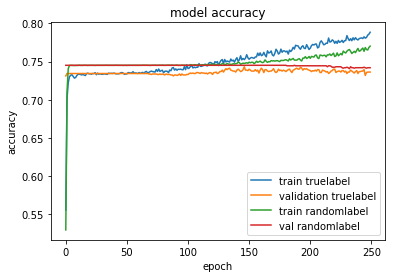

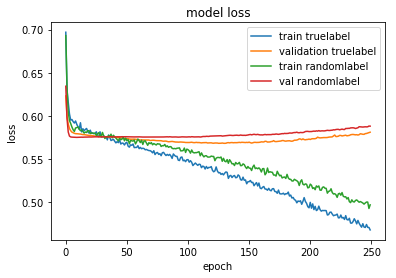

In [20]:
print("Mean loss across all CV sets with true labels:", np.mean([cvscores[i][0] for i in range(len(cvscores))]))
print("Mean loss across all CV sets with random labels:", np.mean([cvscoresrandom[i][0] for i in range(len(cvscoresrandom))]))
print("Mean accuracy across all CV sets with true labels:", np.mean([cvscores[i][1] for i in range(len(cvscores))]))
print("Mean accuracy across all CV sets with random labels:", np.mean([cvscoresrandom[i][1] for i in range(len(cvscoresrandom))]))

print("Lowest val_loss of", min(np.mean([history[i].history['val_loss'] for i in range(n_splits)],axis=0)), "at epoch", np.where(np.mean([history[i].history['val_loss'] for i in range(n_splits)],axis=0)==min(np.mean([history[i].history['val_loss'] for i in range(n_splits)],axis=0)))[0], "with true labels")
print("Lowest val_loss of", min(np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)],axis=0)), "at epoch", np.where(np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)],axis=0)==min(np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)],axis=0)))[0],"with random labels")
acc=np.mean([history[i].history['acc'] for i in range(n_splits)], axis=0)
valacc=np.mean([history[i].history['val_acc'] for i in range(n_splits)], axis=0)
loss=np.mean([history[i].history['loss'] for i in range(n_splits)], axis=0)
valloss=np.mean([history[i].history['val_loss'] for i in range(n_splits)], axis=0)
randacc=np.mean([historyrandom[i].history['acc'] for i in range(n_splits)], axis=0)
randvalacc=np.mean([historyrandom[i].history['val_acc'] for i in range(n_splits)], axis=0)
randloss=np.mean([historyrandom[i].history['loss'] for i in range(n_splits)], axis=0)
randvalloss=np.mean([historyrandom[i].history['val_loss'] for i in range(n_splits)], axis=0)

# summarize history for accuracy
plt.plot(acc)
plt.plot(valacc)
plt.plot(randacc)
plt.plot(randvalacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train truelabel', 'validation truelabel', 'train randomlabel', 'val randomlabel'], loc='best')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(valloss)
plt.plot(randloss)
plt.plot(randvalloss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train truelabel', 'validation truelabel', 'train randomlabel', 'val randomlabel'], loc='best')
plt.show()